## Potrebne biblioteke:
- numpy
- scipy
- sounddevice
- matplotlib
- rtttl (koristi se za parsiranje jezika za specifikaciju melodija)

rtttl biblioteku instalirati komandom: `pip install rtttl`

In [142]:
# Izvrsiti kod koji sadrzi potrebne importe i pomocne funkcije
%matplotlib notebook
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as pyplot
import numpy.random as random
import sounddevice as sd
import math
import rtttl

# Kod za plot dtft-a koristen na vjezbama
def plot_dtft(x, fs):
    from scipy.fftpack import rfft, rfftfreq
    
    L = np.int(2**np.ceil(np.log2(len(x))))
    X = rfft(x, L)
    X /= L
    F = rfftfreq(L, 1/fs)
    
    pyplot.figure()
    pyplot.plot(F, 20*np.log10(np.abs(X)))
    pyplot.xlabel('F [Hz]')
    pyplot.ylabel('|X(F)| [dB]')

def normalizeFloat(sound):
    return sound / np.amax(np.abs(sound))

def delaySound(sound, fs, delay):
    padSamples = round(fs * delay)
    return np.pad(sound, (padSamples, 0), mode = "constant", constant_values = 0)

def padSound(sound, samples):
    if sound.size >= samples:
        return sound
    return np.pad(sound, (0, samples - sound.size), mode = "constant", constant_values = 0)
    
def generateSilence(s, fs):
    samples = round(s * fs)
    return np.zeros(samples)

def padAndSum(sound1, sound2):
    padding = max(sound1.size, sound2.size)
    return padSound(sound1, padding) + padSound(sound2, padding)

cMajor = [261.6256, 293.6648, 329.6276, 349.2282, 391.9954, 440.0000, 493.8833, 523.2511]

### Odredjivanje funkcije prenosa
<img src="image/ks1.jpg" />

Primjecujemo sa slike da vazi:
$$Y(Z) = A(Z)Z^{-N}$$
$$A(Z) = X(Z) + Y(Z)H_d(Z)$$
Uvrstavanjem druge jednacine u prvu i izrazavanjem $Y(Z)$ dobijamo:
$$ Y(Z) = \frac{X(Z)Z^{-N}}{1 - H_d(Z)Z^{-N}}$$ 
Djeljenjem jednacine sa $X(Z)$ dobijamo:
$$ H(Z) = \frac{Z^{-N}}{1 - H_d(Z)Z^{-N}}$$
Uvrstavanjem $H_d(Z) = \frac{1 + Z^{-N}}{2}$ dobijamo funkciju prenosa za dati sistem sa slike:
$$H(Z) = \frac{2Z^{-N}}{2 - Z^{-N} - Z^{-N - 1}}$$
Odgovarajuca jednacina diferencija:
$$ 2y(n) - y(n - N) - y(n - N - 1) = 2x(n - N) $$
Iz jednacine diferencija dobijamo koeficijente koje koristimo za implementaciju filtra
$$b_N =2, a_0 = 2, a_N = -1, a_{N+1} = -1 $$ 

<IPython.core.display.Javascript object>


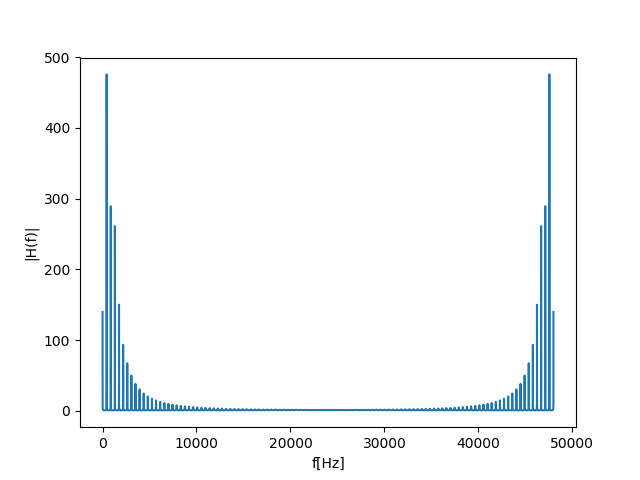

<IPython.core.display.Javascript object>


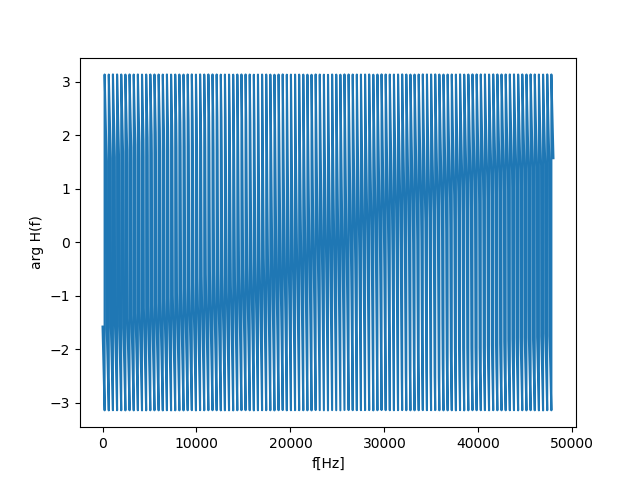

In [241]:
# 2 Tacka

f = 440
FS = 48000
N = round(FS / f - 0.5)
b = np.zeros(N + 1)
a = np.zeros(N + 2)

# Koeficijenti dobijeni iz jednacine diferencija
(b[N], a[0], a[N], a[N + 1]) = (2, 2, -1, -1)

(w, H) = signal.freqz(b, a, FS * 2, True, fs = FS)

# Amplitudni spektar
pyplot.figure()
pyplot.xlabel("f[Hz]")
pyplot.ylabel("|H(f)|")
pyplot.plot(w, np.abs(H))

#Fazni spektar
pyplot.figure()
pyplot.xlabel("f[Hz]")
pyplot.ylabel("arg H(f)")
pyplot.plot(w, np.angle(H))

In [170]:
# Tacka 3

# Rezultat funkcije je trojka(vremenska osa, dobijena frekvencija, sintetizovan zvuk)
def karplusStrong(f, fs, l):
    N = round(fs / f - 0.5)
    actualFreq = FS / (N + 0.5)
    (b, a) = (np.zeros(N + 1), np.zeros(N + 2))
    (b[N], a[0], a[N], a[N + 1]) = (2, 2, -1, -1)
    totalSamples = round(l * fs)
    
    # Generisanje bijelog suma
    noise = random.normal(0, 1, N)
    
    # Dodavanje nula na kraj generisanog ulaza (s ciljem da se dobije zvuk zeljenog trajanja)
    inputNoise = padSound(noise, totalSamples)
    result = signal.lfilter(b, a, inputNoise)
    
    # Normalizacija odmjeraka na opseg (-1, 1)
    normalized = normalizeFloat(result)
    
    
    time = np.linspace(0, l, totalSamples)
    return time, actualFreq, normalized

<IPython.core.display.Javascript object>


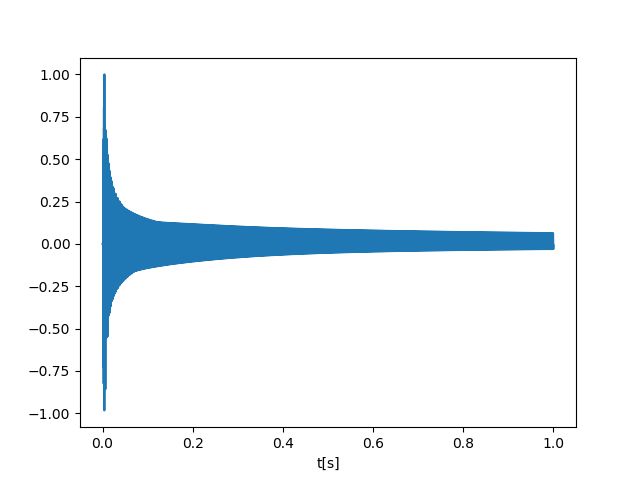

<IPython.core.display.Javascript object>


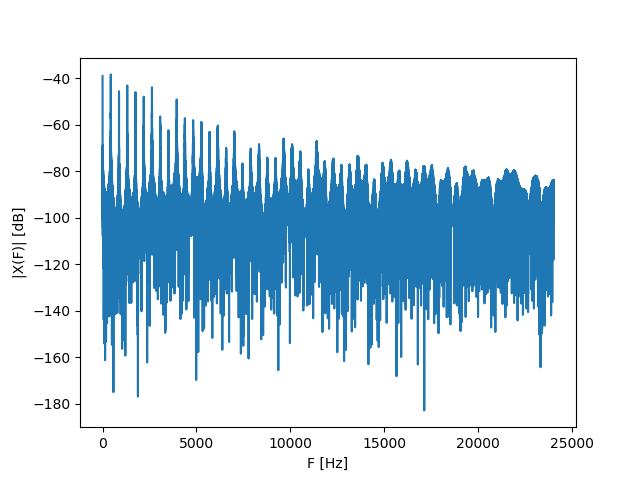

In [169]:
# Tacka 4
l = 1
FS = 48000
f = 440
(time, actualFreq, synth) = karplusStrong(f, FS, l)
sd.play(synth, FS)
pyplot.figure()
pyplot.xlabel("t[s]")
pyplot.plot(time, synth)
plot_dtft(synth, FS)
wavfile.write(f"{f}.wav", FS, synth.astype(np.float32))

In [167]:
# Tacka 5
# Generisanje c-dur ljestvice
cMajorActualFreq = []
FS = 48000
l = 0.8
result = np.array([])
# U svakoj iteraciji generisemo ton frekvencije iz c-dur ljestvice
for i, freq in enumerate(cMajor):
    time, actualFreq, synth = karplusStrong(freq, FS, l)
    cMajorActualFreq.append(actualFreq)
    result = np.concatenate((result, synth))
sd.play(result, FS)

wavfile.write("c major.wav", FS, result.astype(np.float32))
print("C dur frekvencije: ", cMajor)
print("Dobijene frekvencije: ", cMajorActualFreq)
print("Razlika: ", np.abs(np.array(cMajor) - np.array(cMajorActualFreq)))

C dur frekvencije:  [261.6256, 293.6648, 329.6276, 349.2282, 391.9954, 440.0, 493.8833, 523.2511]
Dobijene frekvencije:  [261.58038147138967, 293.57798165137615, 329.89690721649487, 349.09090909090907, 391.83673469387753, 438.35616438356163, 492.3076923076923, 524.5901639344262]
Razlika:  [0.04521853 0.08681835 0.26930722 0.13729091 0.15866531 1.64383562
 1.57560769 1.33906393]


<IPython.core.display.Javascript object>


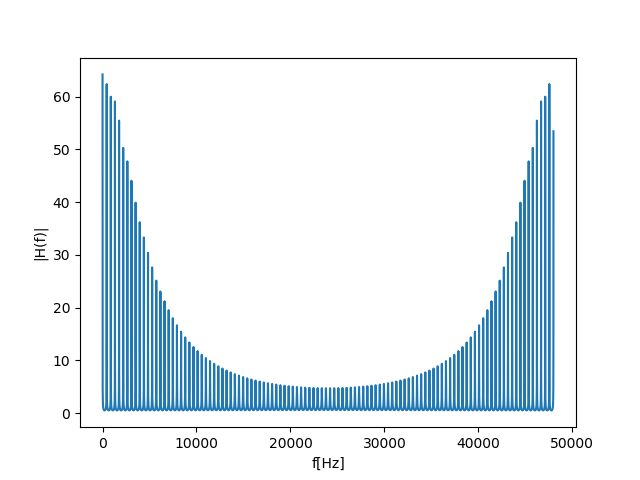

<IPython.core.display.Javascript object>


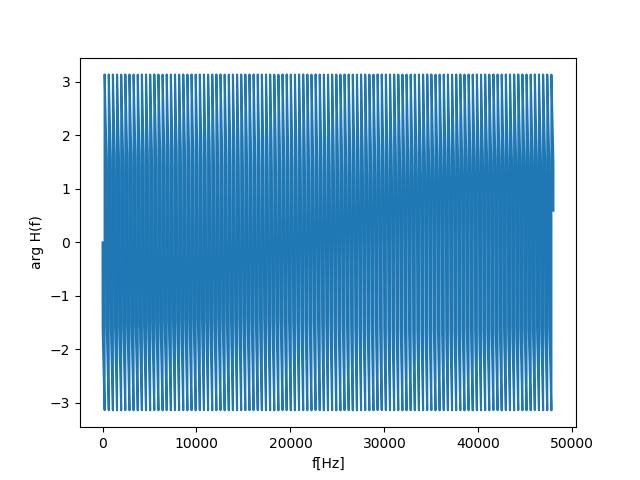

In [228]:
f = 440
FS = 48000

S = 0.1
t60 = 1
N = round(FS / f - 0.5)
b = np.zeros(N + 1)
a = np.zeros(N + 2)
ro = 0.001 ** (1 / (f * t60))

(b[N], a[0], a[N], a[N + 1]) = (1, 1, -ro * (1 - S), -ro * S)
(w, H) = signal.freqz(b, a, 2 ** 16, True)
pyplot.figure()
pyplot.xlabel("f[Hz]")
pyplot.ylabel("|H(f)|")
freqAxis = (w * FS) / (2 * np.pi)
pyplot.plot(freqAxis, np.abs(H))
pyplot.figure()
pyplot.xlabel("f[Hz]")
pyplot.ylabel("arg H(f)")
pyplot.plot(freqAxis, np.angle(H))

## Funkcija prenosa filtra sa kontrolom trajanja tona

Jedina razlika u odnosu na prethodni sistem jeste filtar u povratnoj grani.
$$H_d(Z) = \rho(1 - S) + \rho S Z^{-1}$$
Uvrstavanjem $H_d(Z)$ u prethodno izvedenu funkciju prenosa za proizvoljan filtar u povratnoj grani dobijamo:
$$ H(Z) = \frac{Z^{-N}}{1 - Z^{-N}(\rho(1 - S) + \rho SZ^{-1})} $$
Sredjivanjem dobijamo:
$$ H(Z) = \frac{Z^{-N}}{1 - \rho(1 - S)Z^{-N} - \rho SZ^{-N - 1}} $$
Jednacina diferencija:
$$ y(n) - \rho(1 - S)y(n - N) - \rho Sy(n - N - 1) = x(n - N) $$
Koeficijenti:
$$ b_N = 1, a_0 = 1, a_N = -\rho(1 - S), a_{N + 1} = -\rho S $$

In [8]:
# Tacka 6
# Implementacija filtra
def karplusStrong2(f, fs, l, S, t60):
    N = round(fs / f - 0.5)
    actualFreq = FS / (N + 0.5)
    b = np.zeros(N + 1)
    a = np.zeros(N + 2)
    ro = 0.001 ** (1 / (f * t60))
    (b[N], a[0], a[N], a[N + 1]) = (1, 1, -ro * (1 - S), -ro * S)
    totalSamples = round(l * fs)
    noise = random.normal(0, 1, N)
    inputNoise = np.concatenate((noise, np.zeros(totalSamples - N)))
    result = signal.lfilter(b, a, inputNoise)
    normalized = normalizeFloat(result)
    time = np.linspace(0, l, totalSamples)
    return time, actualFreq, normalized

In [174]:
# Demonstracija uticaja razlicitih parametara na ton frekvencije 440 herca
f = 440
FS = 48000
l = 3
params = [(0.1, 1,), (0.2, 1), (0.4, 1), (0.5, 1), 
          (0.8, 1), (0.9, 1), (0.5, 0.5), (0.5, 1), (0.5, 1.5), (0.5, 2)]

for param in params:
    synth = karplusStrong2(f, FS, l, param[0], param[1])[2]
    print(f"S = {param[0]}, t60 = {param[1]}")
    sd.play(synth, FS)
    sd.wait()

S = 0.1, t60 = 1
S = 0.2, t60 = 1
S = 0.4, t60 = 1
S = 0.5, t60 = 1
S = 0.8, t60 = 1
S = 0.9, t60 = 1
S = 0.5, t60 = 0.5
S = 0.5, t60 = 1
S = 0.5, t60 = 1.5
S = 0.5, t60 = 2


In [317]:
# Tacka 7
FS = 48000
l = 0.8
S = 0.5
t60 = 2
params = [(0.1, 1,), (0.2, 1), (0.4, 1), (0.5, 1), 
          (0.8, 1), (0.9, 1), (0.5, 0.5), (0.5, 1), (0.5, 1.5), (0.5, 2)]

def generateCMajor(FS, l, S, t60):
    result = np.array([])
    for freq in cMajor:
        synth = karplusStrong2(freq, FS, l, S, t60)[2]
        result = np.concatenate((result, synth))
    return result

for param in params:
    print(f"S = {param[0]}, t60 = {param[1]}")
    cMajorSynth = generateCMajor(FS, l, param[0], param[1])
    sd.play(cMajorSynth, FS)
    wavfile.write(f"c major_S={S}_t60={t60}.wav", FS, cMajorSynth.astype(np.float32))
    sd.wait()

S = 0.1, t60 = 1
S = 0.2, t60 = 1
S = 0.4, t60 = 1
S = 0.5, t60 = 1
S = 0.8, t60 = 1
S = 0.9, t60 = 1
S = 0.5, t60 = 0.5
S = 0.5, t60 = 1
S = 0.5, t60 = 1.5
S = 0.5, t60 = 2


## Filtar sa kontrolom polozaja trzalice
<img src="image/ksb.jpg"/>
Funkcija prenosa zeljenog filtra se dobije mnozenjem $H_b(Z)$ i funkcije prenosa filtra iz prethodne tacke (oznaceno sa $H'(Z)$).
$$ H_b(Z) = 1 - Z^{-\lfloor \beta N \rfloor} $$
$$ H(Z) = H_b(Z)H'(Z) $$

$$ H(Z) = \frac{Z^{-N} - Z^{-N - \lfloor \beta N \rfloor}}{1 - \rho(1 - S)Z^{-N} - \rho SZ^{-N - 1}} $$

Jednacina diferencija:
$$ y(n) - \rho(1 - S)y(n - N) - \rho Sy(n - N - 1) = x(n - N) - x(n - N - \lfloor \beta N \rfloor) $$

Koeficijenti:
$$ b_N = 1, b_{N + \lfloor \beta N \rfloor} = -1, a_0 = 1, a_N = -\rho(1 - S), a_{N + 1} = -\rho S $$

In [16]:
# Tacka 8
# Implementacija filtra
def karplusStrongFilter(f, fs, l, S, t60, beta):
    N = round(FS / f - 0.5)
    actualFreq = FS / (N + 0.5)
    betaN = math.floor(beta * N)
    b = np.zeros(N + betaN + 1)
    a = np.zeros(N + 2)
    ro = 0.001 ** (1 / (f * t60))
    (b[N], b[N + betaN], a[0], a[N], a[N + 1]) = (1, -1, 1, -ro * (1 - S), -ro * S)
    totalSamples = round(l * fs)
    noise = random.normal(0, 1, N)
    inputNoise = np.concatenate((noise, np.zeros(totalSamples - N)))
    result = signal.lfilter(b, a, inputNoise)
    normalized = normalizeFloat(result)
    time = np.linspace(0, l, totalSamples)
    return time, actualFreq, normalized

In [96]:
# Demonstracija uticaja beta parametra na ton frekvencije 440 herca
f = 440
FS = 48000
l = 3
S = 0.5
t60 = 1

params = [0.1, 0.3, 0.5, 0.7, 0.9]

for param in params:
    synth = karplusStrongFilter(f, FS, l, S, t60, param)[2]
    print(f"beta = {param}")
    sd.play(synth, FS)
    sd.wait()

beta = 0.1
beta = 0.3
beta = 0.5
beta = 0.7
beta = 0.9


In [17]:
# Tacka 9
# Demonstracija uticaja beta parametra na tonove c-dur ljestvice
FS = 48000
l = 1
S = 0.5
t60 = 3
params = [0.01, 0.1, 0.5, 0.9]

def generateCMajor(FS, l, S, t60, beta):
    result = np.array([])
    for freq in cMajor:
        synth = karplusStrongFilter(freq, FS, l, S, t60, beta)[2]
        result = np.concatenate((result, synth))
    return result

for param in params:
    print(f"beta = {param}")
    cMajorSynth = generateCMajor(FS, l, S, t60, param)
    sd.play(cMajorSynth, FS)
    wavfile.write(f"c major_S={S}_t60={t60}_beta={param}.wav", FS, cMajorSynth.astype(np.float32))
    sd.wait()

beta = 0.01
beta = 0.1
beta = 0.5
beta = 0.9


In [93]:
# Tacka 10
# Implementacija filtra


def overdriveFilter(sample):
    if sample >= 1:
        return 2 / 3
    elif sample <= -1:
        return -2 / 3
    else:
        return sample - (sample ** 3) / 3
    
def karplusStrongOD(f, fs, l, S, t60, beta, g):
    N = round(FS / f - 0.5)
    actualFreq = FS / (N + 0.5)
    betaN = math.floor(beta * N)
    b = np.zeros(N + betaN + 1)
    a = np.zeros(N + 2)
    ro = 0.001 ** (1 / (f * t60))
    (b[N], b[N + betaN], a[0], a[N], a[N + 1]) = (1, -1, 1, -ro * (1 - S), -ro * S)
    totalSamples = round(l * fs)
    noise = random.normal(0, 1, N)
    inputNoise = np.concatenate((noise, np.zeros(totalSamples - N)))
    result = signal.lfilter(b, a, inputNoise)
    result *= g
    overdrive = np.vectorize(overdriveFilter)
    normalized = overdrive(result)
    time = np.linspace(0, l, totalSamples)
    return time, actualFreq, normalized


<IPython.core.display.Javascript object>


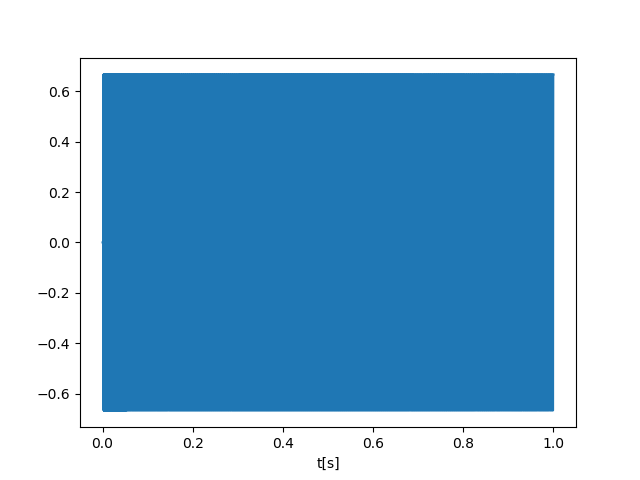

In [94]:
f = 440
FS = 48000
l = 1
S = 0.5
t60 = 2
beta = 0.5
g = 100
time, actualFreq, synth = karplusStrongOD(f, FS, l, S, t60, beta, g)
pyplot.figure()
pyplot.xlabel("t[s]")
pyplot.plot(time, synth)

In [96]:
# Tacka 11
# Demonstracija uticaja g parametra na tonove C-dur ljestvice.
FS = 48000
l = 1
S = 0.5
t60 = 3
g = 1000
beta = 0.5

def generateCMajor(FS, l, S, t60, beta, g):
    result = np.array([])
    for freq in cMajor:
        synth = karplusStrongOD(freq, FS, l, S, t60, beta, g)[2]
        result = np.concatenate((result, synth))
    return result

cMajorSynth = generateCMajor(FS, l, S, t60, beta, g)
sd.play(cMajorSynth, FS)
wavfile.write(f"c major_S={S}_t60={t60}_beta={param}_g={g}.wav", FS, cMajorSynth.astype(np.float32))

In [98]:
# Tacka 12
# Funkcija za generisanje akorda
# Prvi argument je niz frekvencija, drugi argument frekvecija odmjeravanja, treci argument duzina generisanog akorda.
# Ukoliko elemenat u prvom nizu je par(tuple) onda je prvi elemenat u paru frekvencija, a drugi kasnjenje tona u sekundama.
# Koristen je filtar sa kontrolom trajanja tona
def generateChord(freqs, fs, l):
    result = None
    
    for freq in freqs:
        synth = None
        delay = None
        genFreq = None
        
        if isinstance(freq, tuple):
            genFreq = freq[0]
            delay = freq[1]
        else:
            genFreq = freq
            
        synth = karplusStrong2(genFreq, FS, l, 0.5, 2)[2]
        
        if delay is not None:
            synth = delaySound(synth, fs, delay)
            
        if result is None:
            result = synth
        else:
            result = padAndSum(result, synth)
    
    return normalizeFloat(result)

In [99]:
FS = 48008
l = 5
# C akord
# Ton sa frekvencijom 329 herca je zakasnjen za 100ms, a ton frekvencije 392 herca za 0.2 sekunde
result = generateChord([261.6256, (329.6276, 0.1), (391.9954, 0.2)], FS, l)
sd.play(result, FS)

In [104]:
# Tacka 13
# Super mario brothers
# Koristena rtttl biblioteka za parsiranje nokia RTTTL formata za prenos tonova
parsedRtttl = None
with open("smb.txt") as file:
     parsedRtttl = rtttl.parse_rtttl(file.read())
    
FS = 48000
result = np.array([])
for tone in parsedRtttl["notes"]:
    
    # tone["duration"] u ms
    (freq, duration) = (tone["frequency"], tone["duration"] / 1000)
    if freq == 0:
        synth = generateSilence(duration, FS)
    else:
        synth = karplusStrong2(freq, FS, duration, 0.1, 2)[2]
    result = np.concatenate((result, synth))

sd.play(result, FS)